### I found an exciting phenomena that it seems shrinking stepsizes of the mockdata could make the constraints nice. I now can't wait to try the same thing with the NR data. But they don't have 0.01 stepsizes, so I have to do some interpolation to taste a first test of our guess.

In [24]:
#Import relevant modules, import data and all that
import numpy as np
from scipy import interpolate
import corner
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
#plt.rcParams['font.family'] = 'DejaVu Sans'
#rc('text', usetex=True)
plt.rcParams.update({'font.size': 16.5})

import ptemcee
from pycbc.pool import choose_pool
import h5py
import inspect
import pandas as pd
import json
import qnm
import random

#Remember to change the following global variables
#rootpath: root path to nr data
#npoints: number of points you re using for your sampling
#nmax: tone index --> nmax = 0 if fitting the fundamental tone
#tshift: time shift after the strain peak
#vary_fund: whether you vary the fundamental frequency. Works in the model_dv function.

rootpath= "/Users/RayneLiu"#"/work/rayne.liu"
nmax=1
tshift=0
vary_fund = True

#sampler parameters
npoints = 4000
nwalkers = 2000
ntemps=16
dim = nmax+1
ndim = 4*dim
burnin = 100  #How many points do you burn before doing the corner plot. You need to watch the convergence of the chain plot a bit.
            #This is trivial but often forgotten: this cannot be more than npoints! Usually 1/5~1/4 npoints is what I observe.
numbins = 42 #corner plot parameter - how many bins you want
datacolor = '#105670' #'#4fa3a7'
pkcolor = '#f2c977' #'#ffb45f'
mediancolor = '#f7695c' #'#9b2814'

#Import data and necessary functions

#TimeOfMaximum
def FindTmaximum(y):
    #Determines the maximum absolute value of the complex waveform
    absval = y[:,1]*y[:,1]+y[:,2]*y[:,2]
    vmax=np.max(absval)
    index = np.argmax(absval == vmax)
    timemax=gw_sxs_bbh_0305[index,0]
    return timemax




#This loads the 22 mode data
gw = {}
gw["SXS:BBH:0305"] = h5py.File(rootpath+"/git/rdstackingproject/SXS/BBH_SKS_d14.3_q1.22_sA_0_0_0.330_sB_0_0_-0.440/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5", 'r')
gw_sxs_bbh_0305 = gw["SXS:BBH:0305"]["Extrapolated_N2.dir"]["Y_l2_m2.dat"]

# Remember to download metadata.json from the simulation with number: 0305. Download Lev6/metadata.json
# This postprocesses the metadata file to find the final mass and final spin
metadata = {}
with open(rootpath+"/git/rdstackingproject/SXS/BBH_SKS_d14.3_q1.22_sA_0_0_0.330_sB_0_0_-0.440/Lev6/metadata.json") as file:
    metadata["SXS:BBH:0305"] = json.load(file)

af = metadata["SXS:BBH:0305"]['remnant_dimensionless_spin'][-1]
mf = metadata["SXS:BBH:0305"]['remnant_mass']



#times --> x axis of your data
times = gw_sxs_bbh_0305[:,0]
tmax=FindTmaximum(gw_sxs_bbh_0305)
t0=tmax +tshift

#Select the data from t0 onwards
position = np.argmax(times >= (t0))
gw_sxs_bbh_0305rd=gw_sxs_bbh_0305[position:-1]
timesrd=gw_sxs_bbh_0305[position:-1][:,0][:920]
#print(timesrd[0])
#print(t0) (This checks that timesrd[0] is indeed t0)
timespan = timesrd - t0
gwdata_re = gw_sxs_bbh_0305rd[:,1][:920]
gwdata_im = gw_sxs_bbh_0305rd[:,2][:920]

# Depending on nmax, you load nmax number of freqs. and damping times from the qnm package
omegas = [qnm.modes_cache(s=-2,l=2,m=2,n=i)(a=af)[0] for i in range (0,dim)]
w = (np.real(omegas))/mf
tau=-1/(np.imag(omegas))*mf

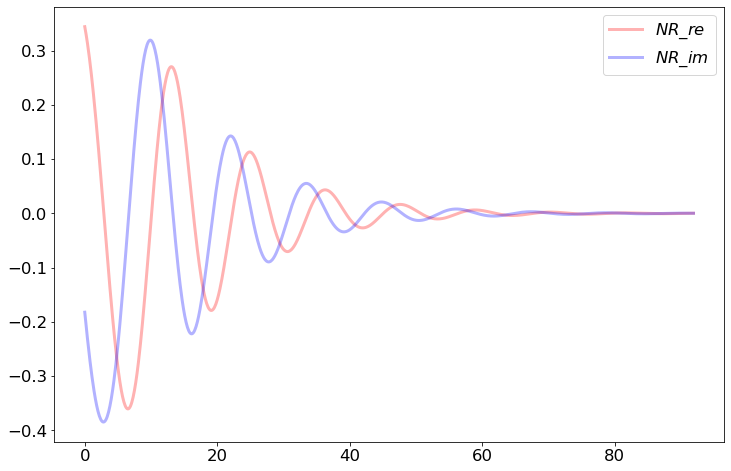

In [2]:
#Test plot (data was picked in the last cell)
plt.figure(figsize = (12, 8))
plt.plot(timespan, gwdata_re, "r", alpha=0.3, lw=3, label=r'$NR\_re$')
plt.plot(timespan, gwdata_im, "b", alpha=0.3, lw=3, label=r'$NR\_im$')
plt.legend()

In [3]:
gwdata_re.shape

(920,)

In [4]:
gwnew_re = interpolate.interp1d(timespan, gwdata_re, kind = 'cubic')
gwnew_im = interpolate.interp1d(timespan, gwdata_im, kind = 'cubic')

In [5]:
timespan

array([ 0.        ,  0.09998599,  0.19997187,  0.29995762,  0.39994326,
        0.49992877,  0.59991415,  0.69989942,  0.79988456,  0.89986957,
        0.99985446,  1.09983923,  1.19982386,  1.29980838,  1.39979276,
        1.49977702,  1.59976115,  1.69974514,  1.79972901,  1.89971275,
        1.99969636,  2.09967984,  2.19966319,  2.2996464 ,  2.39962949,
        2.49961244,  2.59959525,  2.69957794,  2.79956049,  2.8995429 ,
        2.99952518,  3.09950732,  3.19948933,  3.2994712 ,  3.39945293,
        3.49943453,  3.59941599,  3.69939731,  3.7993785 ,  3.89935954,
        3.99934045,  4.09932121,  4.19930184,  4.29928232,  4.39926267,
        4.49924287,  4.59922294,  4.69920286,  4.79918264,  4.89916228,
        4.99914177,  5.09912112,  5.19910033,  5.2990794 ,  5.39905832,
        5.4990371 ,  5.59901573,  5.69899422,  5.79897256,  5.89895076,
        5.99892881,  6.09890672,  6.19888448,  6.2988621 ,  6.39883956,
        6.49881688,  6.59879406,  6.69877108,  6.79874796,  6.89

In [6]:
timespan_new = np.linspace(0, timespan[-1], len(timespan)*10)
gwdatanew_re = gwnew_re(timespan_new)
gwdatanew_im = gwnew_im(timespan_new)

In [7]:
timespan_new[-1]

91.87835926832486

In [8]:
timespan_new[0]

0.0

In [9]:
timespan_new.shape

(9200,)

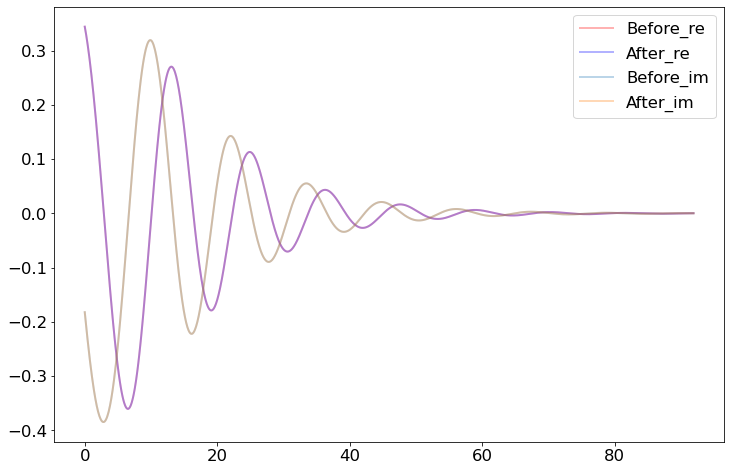

In [10]:
#Test the new interpolated data
plt.figure(figsize = (12, 8))
plt.plot(timespan, gwdata_re, "r", alpha=0.3, lw=2, label='Before_re')
plt.plot(timespan_new, gwdatanew_re, "b", alpha=0.3, lw=2, label='After_re')
plt.plot(timespan, gwdata_im, alpha=0.3, lw=2, label='Before_im')
plt.plot(timespan_new, gwdatanew_im, alpha=0.3, lw=2, label='After_im')
plt.legend()

### Now the interpolation seems nice according to what we have above...let's start sampling!

In [20]:
#Fitting
#RD model for nmax tones. Amplitudes are in (xn*Exp[i yn]) version. Used here.
def model_dv(theta):
    #x0, y0= theta
    #Your nmax might not align with the dim of theta. Better check it here.
    assert int(len(theta)/4) == dim, 'Please recheck your n and parameters'
    
    avars = theta[ : (dim)]
    bvars = theta[(dim) : 2*(dim)]
    xvars = theta[2*(dim) : 3*(dim)]
    yvars = theta[3*(dim) : ]
    
    if vary_fund == False:
        avars[0]=0
        bvars[0]=0
        
    ansatz = 0
    for i in range (0,dim):
        #bvars[1]=0
        #avars[1]=0
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timespan_new/(tau[i]*(1+bvars[i]))) * (np.cos((1+avars[i])*w[i]*timespan_new)-1j*np.sin((1+avars[i])*w[i]*timespan_new))
    # -1j to agree with SXS convention
    return ansatz

# Logprior distribution. It defines the allowed range my variables can vary over. 
#It works for the (xn*Exp[iyn]) version. 
def log_prior(theta): 
    #Warning: we are specifically working with nmax=1 so here individual prior to the parameters are manually adjusted. This does not apply to all other nmax's.
    #avars = theta[ : (dim)]
    #bvars = theta[(dim) : 2*(dim)]
    #xvars = theta[2*(dim) : 3*(dim)]
    #yvars = theta[3*(dim) : ]
    alpha0, alpha1, beta0, beta1, xvar0, xvar1, yvar0, yvar1 = theta
    if all([-0.9 <= alpha0 <= 0.9, -0.9 <= alpha1 <= 0.9, -0.5 <= beta0 <= 2.0, -1.0 <= beta1 <= 2.7, \
        0 <= xvar0 <= 6, 0 <= xvar1 <= 6, -np.pi <= yvar0 <= np.pi, -np.pi <= yvar1 <= np.pi]):        
        return 0.0
    """
    if nmax == 0:
        if all([0 <= tshift <= 5, vary_fund == True, -0.45 <= avars[0] <= 0.05, -0.95 <= bvars[0] <= 3.0, 0 <= xvars[0] <= 3.0, -np.pi <= yvars[0] <= np.pi]):        
            return 0.0
        elif all([tshift == 19, vary_fund == True, -3.0 <= avars[0] <= 3.0, -2.0 <= bvars[0] <= 5.0, 0 <= xvars[0] <= 1.0, 0 <= yvars[0] <= 2*np.pi]):        
            return 0.0
        if all([0 <= tshift <= 5, vary_fund == False, -1.0 <= avars[0] <= 1.0, -1.0 <= bvars[0] <= 1.0, 0 <= xvars[0] <= 3.0, -np.pi <= yvars[0] <= np.pi]):        
            return 0.0
        if all([tshift == 19, vary_fund == False, -1.0 <= avars[0] <= 1.0, -1.0 <= bvars[0] <= 1.0, 0 <= xvars[0] <= 3.0, 0 <= yvars[0] <= 2*np.pi]):        
            return 0.0
        
    elif nmax == 1:
        if all([0 <= tshift <= 5, vary_fund == True, -3.0 <= avars[0] <= 3.0, -3.0 <= avars[1] <= 3.0, -2.0 <= bvars[0] <= 12.0, -4.0 <= bvars[1] <= 30.0, 0 <= xvars[0] <= 1.6, 0 <= xvars[1] <= 1.4, -np.pi <= yvars[0] <= np.pi, -np.pi <= yvars[1] <= np.pi]):        
            return 0.0
        elif all([tshift == 19, vary_fund == True, -10.0 <= avars[0] <= 10.0, -10.0 <= avars[1] <= 10.0, -20.0 <= bvars[0] <= 30.0, -25.0 <= bvars[1] <= 30.0, 0 <= xvars[0] <= 0.6, 0 <= xvars[1] <= 0.9, 0 <= yvars[0] <= 2*np.pi, -np.pi <= yvars[1] <= np.pi]):
            return 0.0

        elif all([0 <= tshift <= 5, vary_fund == False, -10.0 <= avars[0] <= 10.0, -1.5 <= avars[1] <= 1.5, -9.0 <= bvars[0] <= 9.0, -6.0 <= bvars[1] <= 20.0, 0 <= xvars[0] <= 2.4, 0 <= xvars[1] <= 2.5, -np.pi <= yvars[0] <= np.pi, -np.pi <= yvars[1] <= np.pi]):
            return 0.0
        elif all([tshift == 19, vary_fund == False, -10.0 <= avars[0] <= 10.0, -8.0 <= avars[1] <= 8.0, -9.0 <= bvars[0] <= 9.0, -10.0 <= bvars[1] <= 12.0, 0 <= xvars[0] <= 0.6, 0 <= xvars[1] <= 0.7, 0 <= yvars[0] <= 2*np.pi, 0 <= yvars[1] <= 2* np.pi]):
            return 0.0
    """
    return -np.inf


# LogLikelihood function. It is just a Gaussian loglikelihood based on computing the residuals^2
def log_likelihood(theta):
    modelev = model_dv(theta)
    result = -np.sum((gwdatanew_re - (modelev.real))**2+(gwdatanew_im - (modelev.imag))**2)
    if np.isnan(result):
        return -np.inf
    return result


# Logposterior distribution for the residuals case.
# The evidence is just a normalization factor
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

Maximum likelihood estimates:
[-0.21369212  0.02663142 -0.39809089  3.00979794  0.72921953  0.45264978
 -1.15012788  1.45880584]


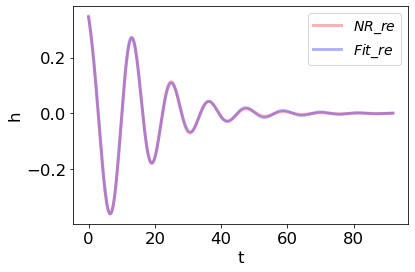

In [12]:
#Check if my fit functions are correct using scipy.minimize
from scipy.optimize import minimize
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
#This assigns the initial guess
initial = np.array([0, 0, 0, 0, 1, 1, 1, 1])
soln = minimize(nll, initial)
print("Maximum likelihood estimates:") #Maximum likelihood: minimum -log_likelihood. Log_likelihood is easier to calculate
vars_ml=soln.x
print(vars_ml)
#Now plot the NR data against the ansatz data
plt.plot(timespan_new, gwdatanew_re, "r", alpha=0.3, lw=3, label=r'$NR\_re$')
modelfit = model_dv(vars_ml)
plt.plot(timespan_new, modelfit.real,"b", alpha=0.3, lw=3, label=r'$Fit\_re$')
#plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlabel("t")
plt.ylabel("h");

The chain plot:


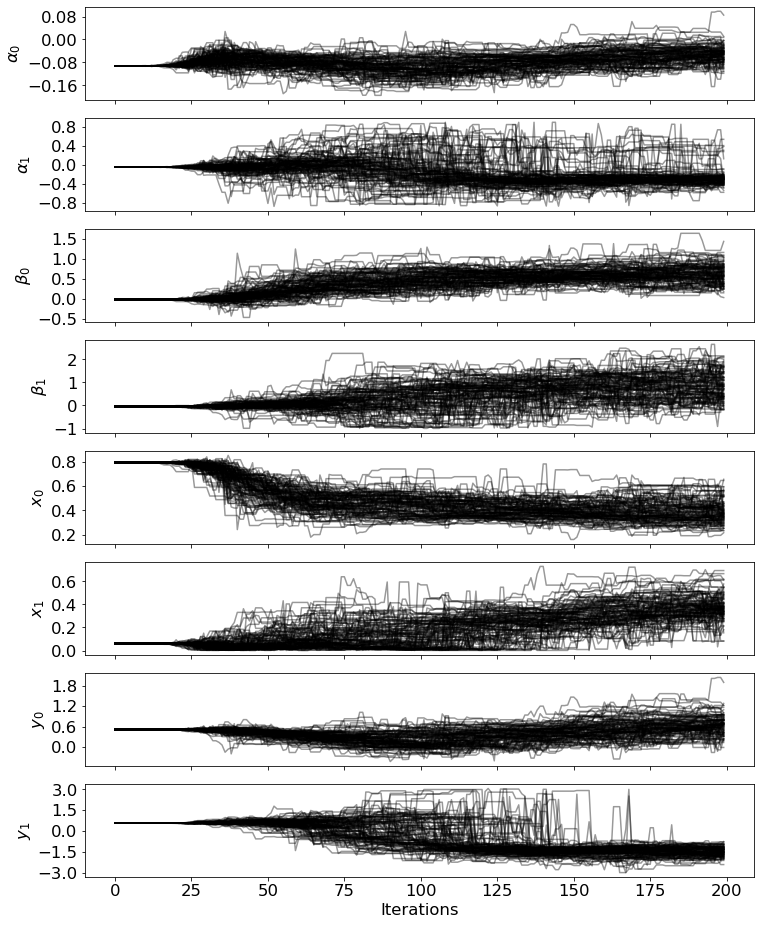

We're using ptemcee. Our constraints:


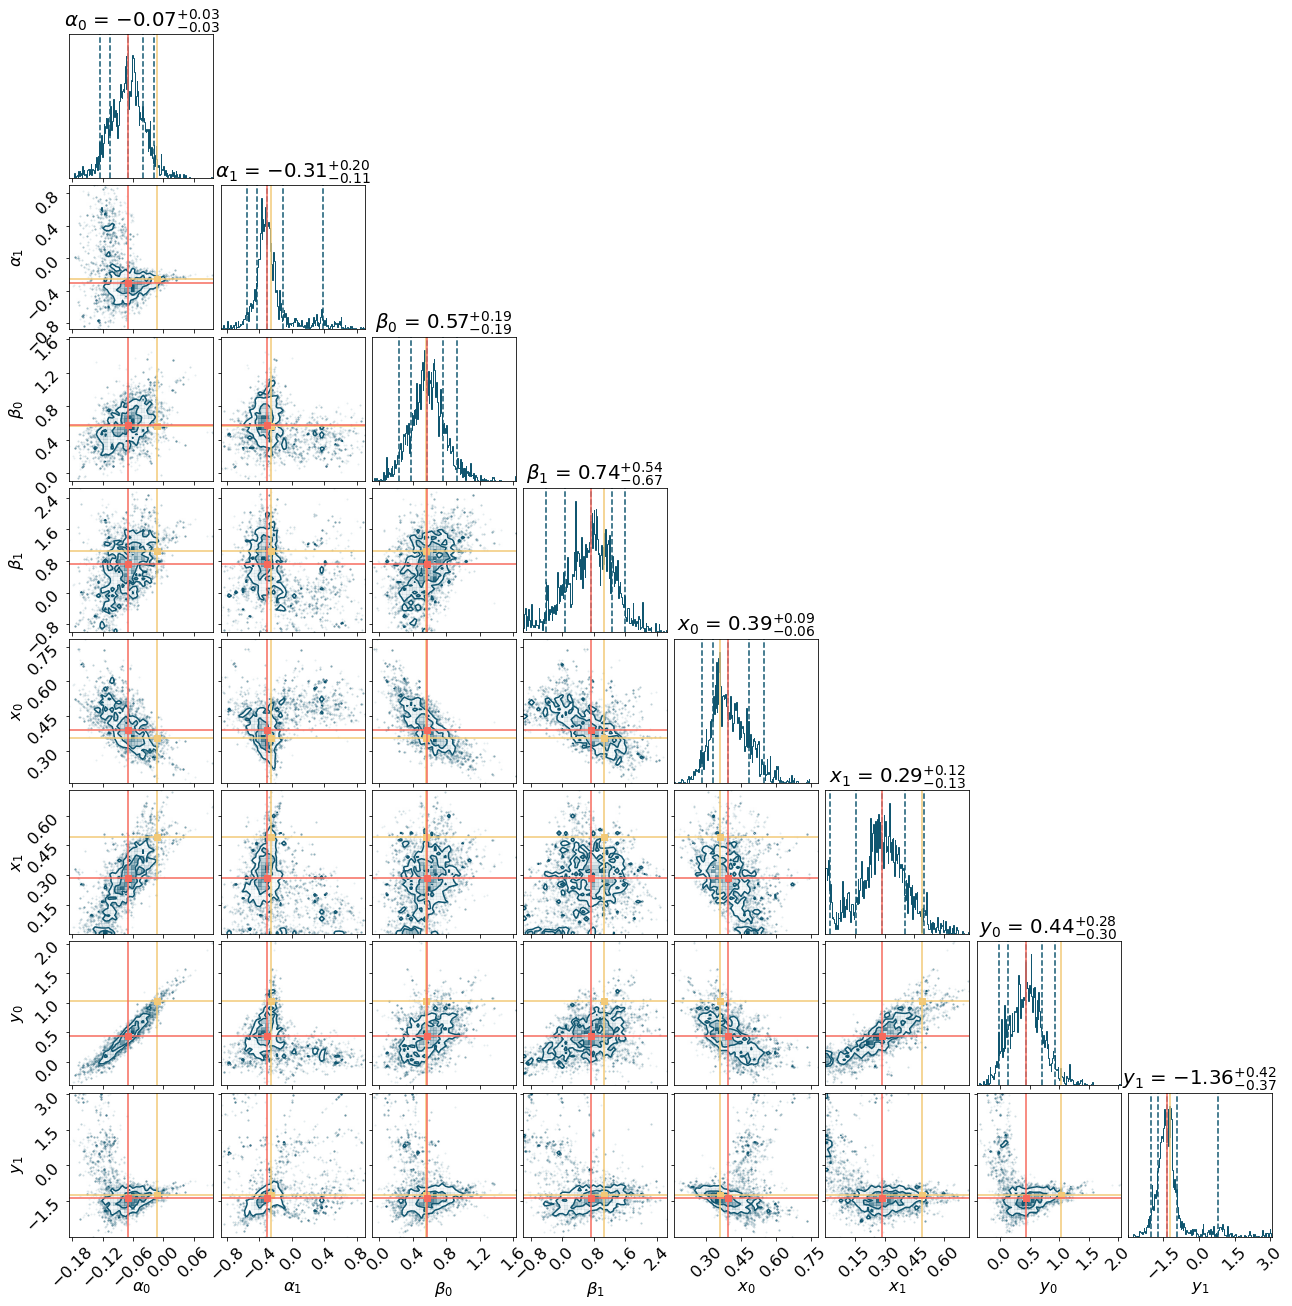

In [25]:
#Ok, nice. Now let's do ptemcee...
np.random.seed(42)
pos = np.array([random.uniform(-0.1,0.), random.uniform(-0.1,0.), random.uniform(-0.1,0.), \
                random.uniform(-0.1,0.), random.uniform(0,1), random.uniform(0, 1), random.uniform(0.5, 0.6), \
                random.uniform(0.5, 0.6)])
pos = list(pos)
pos += 1e-5 * np.random.randn(ntemps, nwalkers, ndim)
sampler = ptemcee.Sampler(nwalkers, ndim, log_likelihood, log_prior, ntemps=ntemps)
sampler.run_mcmc(pos,npoints)

dim = 2
paramlabels_a = [r'$\alpha_'+str(i)+'$' for i in range (dim)]
paramlabels_b = [r'$\beta_'+str(i)+'$' for i in range (dim)]
paramlabels_x = [r'$x_'+str(i)+'$' for i in range (dim)]
paramlabels_y = [r'$y_'+str(i)+'$' for i in range (dim)] 

paramlabels = paramlabels_a + paramlabels_b + paramlabels_x + paramlabels_y

print('The chain plot:')
#Chain plot
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(12, 4*(4)))
for i in range(ndim):
    axes[i].plot(sampler.chain[0,:, :, i].T, color="k", alpha=0.4, rasterized=True)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].set_ylabel(paramlabels[i])
axes[-1].set_xlabel('Iterations')
plt.show()

print('We\'re using ptemcee. Our constraints:')
#Burn samples, calculate peak likelihood value (not necessarily so in atlas) and make corner plot
samples = sampler.chain[0,:, burnin:, :].reshape((-1, ndim))
#samples for corner plot
samples_corn = samples #if vary_fund == True else np.delete(samples, np.s_[0,2], 1)

#print('Values with peak likelihood:')
lglk = np.array([log_likelihood(samples[i]) for i in range(len(samples))])
pk = samples[np.argmax(lglk)]
#print('pk:')
#print(pk)
pk_corn = pk #if vary_fund == True else np.delete(pk, [0,2])
#y_0 range needs some messaging to make the plot. But in order to make the whole picture consistent, better change the range of y_1 too.
#if vary_fund == False:
#    samples_corn.T[-dim:] -= np.pi #This indeed changes samples_corn itself
#    pk[-dim:] -= np.pi

#print('pkFalse:')
#print(pk)
    
#print(pk) 
#Now calculate median (50-percentile) value
median = np.median(samples_corn, axis=0)
#print(samples)
#print(samples_corn)

figcorn = corner.corner(samples_corn, bins = numbins, hist_bin_factor = 5, color = datacolor, truths=pk_corn, truth_color = pkcolor, plot_contours = True, labels = paramlabels, quantiles=(0.05, 0.16, 0.5, 0.84, 0.95), levels=[1-np.exp(-0.5), 1-np.exp(-1.64 ** 2/2)], show_titles=True)


#Extract the axes in order to add more important line plots
naxes = len(pk_corn)
axes = np.array(figcorn.axes).reshape((naxes, naxes))

# Loop over the diagonal
for i in range(naxes):
    ax = axes[i, i]
    ax.axvline(median[i], color=mediancolor)

# Loop over the histograms
for yi in range(naxes):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(median[xi], color=mediancolor)
        ax.axhline(median[yi], color=mediancolor)
        ax.plot(median[xi], median[yi], color = mediancolor, marker = 's')